<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'> 
# &nbsp;How to query for reduced data
<br>

This section of the ["ESO Science Archive Programmatic: HOWTOs"](http://archive.eso.org/programmatic/HOWTO/) shows how to programmatically query the database table that exposes the metadata of the reduced data, using Python. 

_**Usage**: You can access this file either as a static HTML page [(download it here)](http://archive.eso.org/programmatic/HOWTO/jupyter/ESO_How_to_query_for_reduced_data.html), or as an interactive jupyter notebook [(download it here)](http://archive.eso.org/programmatic/HOWTO/jupyter/ESO_How_to_query_for_reduced_data.ipynb) which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will._

The table is called ivoa.ObsCore and it is fully compliant to the so-called **ObsCore** Virtual Observatory standard: [Observation Data Model Core Components and its Implementation in the Table Access Protocol, Version 1.1](http://ivoa.net/documents/ObsCore/index.html), IVOA Recommandation 09 May 2017, Louys et al.

In the following, it will be shown how to query the ivoa.ObsCore table using the [IVOA Astronomical Data Query Language](http://www.ivoa.net/documents/latest/ADQL.html), Version 2, IVOA Recommandation 30 October 2008, Ortiz et al.

You can interact with this jupyter notebook: move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER, modify the code and execute again. Or if you prefer you can download it, and play with it on your machine (link to be provided).

**Table of Content**
1. [**Query by dataset identifier**](#query_by_identifier)
   1. [**Introduction to the ivoa.ObsCore columns**](#obscore_columns_introduction) 
1. [**Query by the data provider file name**](#query_by_origfile)
1. [**Query by coordinates (aka spatial queries)**](#query_by_coordinates)
   1. [**Cone search**](#cone_search)
   1. [**Point in footprint**](#point_in_footprint): datasets containing a user-defined point <small>(e.g., **when looking for SN progenitors**)</small>
   1. [**Region in footprint**](#region_in_footprint): datasets **entirely covering** a user-defined spatial region <small>(e.g., **for image cutout**)</small>
   1. [**Search by polygon**](#polygon_search): datasets spatially intersecting a user-defined polygon <small>(e.g., **looking for counterparts of GW170817**)</small>
1. [**Spatial joins**](#spatial_joins): datasets that spatially overlaps <small>(e.g., **find same sky region covered in different bands, for photometric studies**)
1. [**Query by wavelengths**](#query_by_wavelengths)
1. [**Units of the ivoa.ObsCore columns**](#obscore_columns)

First of all, let's:
* import what is necessary
* define the ESO Tabular Access Protocol (TAP) endpoint to search through the reduced data
* instantiate the TAP service

In [1]:
import os 
import sys

import numpy as np

from astropy.visualization import astropy_mpl_style

from astropy import table
from astropy.coordinates import SkyCoord
from astropy.units import Quantity

from pyvo.dal import tap

import matplotlib.pyplot as plt
import pandas

ESO_TAP_OBS = "http://archive.eso.org/tap_obs"

tapobs = tap.TAPService(ESO_TAP_OBS)

---
## <a id='query_by_identifier'>1. Query by dataset identifier</a>

Each dataset in the archive has been assigned a unique ESO identifier. For reduced products this is a 27-character name whose first 4 characters are 'ADP.' followed by a datetime string, up to the millisecond. Example: ADP.2013-12-10T16:12:17.697
<small>(That timestamp is **not** the datetime when the observation was taken, take it just as a synthetic string without any associated meaning)</small>

Completely equivalently, a Virtual Observatory identifier (colloquially called "ivorn") exists, and takes the form of constant string 'ivo://eso.org/ID?' prepended to the ESO identifier. Example: ivo://eso.org/ID?ADP.2013-12-10T16:12:17.697

The look for a given reduced dataset, the query can be expressed using either the ESO or the VO identifier; the ESO identifier is stored in the ESO-specific non-standard column 'dp_id', while the ivorn is stored in the ObsCore standard column 'obs_publisher_did'. Let's execute the query by 'dp_id', while showing in the comment the 'obs_publisher_did' equivalent: 

In [2]:
dp_id = 'ADP.2013-12-10T16:12:17.697'

query = """SELECT *
FROM ivoa.ObsCore
WHERE dp_id = '%s'""" % (dp_id)

# ivorn = 'ivo://eso.org/ID?' + dp_id
# query = """SELECT *
# FROM ivoa.ObsCore
# WHERE obs_publisher_did = '%s'""" % (ivorn)

print(query)

SELECT *
FROM ivoa.ObsCore
WHERE dp_id = 'ADP.2013-12-10T16:12:17.697'


**Send the ADQL query to the ESO TAP service and get the resulting table**

Beware: the next cell could return some warnings about wrong UCDs; that simply means that you have not yet updated to the latest version of astropy. Anyways, those warnings are not important, and you can continue disregarding them.

Passing the query to the tapobs service and getting its results is easy, thanks to the pyvo module.
The search returns the table of results (res), consisting of a single record given that we constrained the query by a unique identifier.

In [3]:
res = tapobs.search(query=query)

print(res)

<Table length=1>
abmaglim access_estsize ... t_xel target_name
  mag        kbyte      ...                  
float64      int64      ... int64    object  
-------- -------------- ... ----- -----------
      --           1186 ...    --  J0001+0307


### <a id='obscore_columns_introduction'>1.1 Introduction to the ivoa.ObsCore columns</a>
It seems useful before continuing, to have a closer look at the previous result set, so to gain a feeling of the kind of information/columns that can be found in the ObsCore table.

Given the 'SELECT *' in the query above, the result set contains all the ObsCore columns.

The ESO ObsCore table contains 41 columns of the ObsCore standard, plus 9 ESO-specific columns; the ESO-specific are:
* abmaglim (available only for images, catalogtiles, and cubes)
* gal_lat
* gal_lon
* multi_ob
* n_obs
* obstech
* p3orig
* publication_date
* snr (available only for spectra)

The following shows all the returned columns (and their values for the specific dataset).
You can use any of those columns to add constraints in your queries.

To gather full information on each column (like units, description, UCD, etc), please refer to the section [The ivoa.ObsCore columns](#obscore_columns) at the bottom of this page.

In [3]:
for colname in res.to_table().colnames:
    print("{:20s} \t = \t {}".format(colname, res[colname][0]))

NameError: name 'res' is not defined

---
## <a id='query_by_origfile'>2 Query by the data provider file name</a>

In case you know the original file name defined by the data provider before ingestion into the ESO archive, you must use the 'obs_creator_did' column (which is also an ivorn), as shown here:

In [5]:
origfile = 'UV_SFLX_981908_2013-10-31T02:09:09.322_BLU390d1_2x2_11.fits'
ivorn = 'ivo://eso.org/origfile?' + origfile

query = """SELECT *
FROM ivoa.ObsCore
WHERE obs_creator_did = '%s'""" % (ivorn)

print(query)

SELECT *
FROM ivoa.ObsCore
WHERE obs_creator_did = 'ivo://eso.org/origfile?UV_SFLX_981908_2013-10-31T02:09:09.322_BLU390d1_2x2_11.fits'


---
## <a id='query_by_coordinates'>3. Query by coordinates (aka spatial queries)</a>

You are interested in a positional/spatial query, when you want to find products around a certain position in the sky. There are multple ways one can pose such question; it all depends on the use case at hand and which data you are looking for.

On one side, the data...

The reduced data are spatially characterised by their footprint (standard ObsCore column: s_region).
In the previous example, the footprint of the source table ADP.2017-09-14T08:39:35.649 is described by a polygon.
The types of footprins in the ESO archive are:
* a point (this is the case for spectra and visibilities)
* a circle (this is the case for the majority of ALMA data)
* a polygon (e.g. for tile images, catalog tiles, cubes)
* a union of polygons (e.g. uncombined images of a multichip camera, and relative source tables) 

On the other side, your use case...

You might want to apply different criteria, e.g.: 
* 3.A Give me any dataset closer than N arcsec to a certain point
    * this is the typical **cone search**, where it does not matter if the central point is covered or not by the dataset, or how much of the dataset's footprint intersects the defined cone; datasets of all kinds, including the ones with a point-like footprint, can be discovered via this search criterion. <p>
    
* 3.B Give me any dataset covering a certain point,
    * this is the so-called **point in footprint**, useful for example to find progenitors of supernovae in images or cubes. Notice that datasets with point-like footprints cannot be discovered via this criterion, as two points will never coincide.<p>
    
* 3.C Give me any dataset covering a user-defined region **in its entirety**
    * this is the case is similar to 3.B, just that now it is a **region in footprint** and not just a point; for example, this is the case for an image cutout, when you want to be sure that the image contains the entire region of interest before cutting it out.

* 3.D Give me any dataset intersecting a complex region, i.e. **a user-defined polygon**

### <a id='cone_search'>3.A Cone search</a>

Suppose you are looking for datasets closer than _2.5 arcmin_ from _NGC 4666_.

Either you know the equatorial coordinates of your object, or you rely onto a name resolver like SESAME (CDS) to get them. In the end you have a circle defined by the 3 quantities; ra, dec, and radius, all expressed in degrees.

The cone search constraint is defined by the **INTERSECTS operator**, which takes two footprints as input, and return true (1) if the two intersects in at least 1 point, false (0) if they don't.

In a cone search query, one of the two footprints is the input circle, while the other is the _s\_region_ column, which represents the footprint of any dataset.

In [9]:
# Defining the position via SESAME name resolver, and the search radius
target = "HD48611"

pos = SkyCoord.from_name(target)
# pos now contains the coordinates of NGC 4666
print("SESAME coordinates for %s: %s (truncated to millidegrees)\n" % (target, pos.to_string()))

sr = 2.5/60. # search radius of 2.5 arcmin, always expressed in degrees

# Cone search: looking for footprints of reduced datasets intersecting a circle of 2.5' around NGC 4666
query = """SELECT *
FROM ivoa.ObsCore
WHERE intersects(s_region, circle('', %f, %f, %f))=1
""" % (pos.ra.degree , pos.dec.degree, sr)

print(query)

SESAME coordinates for HD48611: 99.4607 -70.9326 (truncated to millidegrees)

SELECT *
FROM ivoa.ObsCore
WHERE intersects(s_region, circle('', 99.460716, -70.932613, 0.041667))=1



In [11]:
res = tapobs.search(query=query, maxrec=1000)
print("Num matching datasets: %d" % (len(res)))
results_table = res.to_table()

Num matching datasets: 71


In [21]:
results_table[results_table['instrument_name'] == 'HARPS']
dp_id_list = list(results_table['dp_id'])
dp_id_list

['ADP.2014-09-16T11:06:55.340',
 'ADP.2014-09-17T11:23:15.513',
 'ADP.2014-09-29T13:27:20.393',
 'ADP.2019-10-22T15:31:20.304',
 'ADP.2016-09-21T11:12:53.976',
 'ADP.2019-10-22T15:31:20.298',
 'ADP.2021-04-15T09:27:01.212',
 'ADP.2014-09-29T13:27:05.220',
 'ADP.2019-10-22T15:31:20.296',
 'ADP.2019-11-05T14:19:26.480',
 'ADP.2014-09-16T11:06:07.303',
 'ADP.2014-10-01T10:19:49.137',
 'ADP.2019-10-22T15:31:20.306',
 'ADP.2019-11-05T14:19:26.473',
 'ADP.2014-09-16T11:04:57.103',
 'ADP.2019-10-22T15:31:20.302',
 'ADP.2019-10-22T15:31:20.308',
 'ADP.2019-11-05T14:19:26.472',
 'ADP.2019-11-05T14:19:26.479',
 'ADP.2021-04-15T09:08:03.631',
 'ADP.2014-09-16T11:03:46.237',
 'ADP.2014-09-16T11:06:49.453',
 'ADP.2019-10-22T15:31:20.292',
 'ADP.2019-10-22T15:31:20.312',
 'ADP.2019-10-22T15:31:20.310',
 'ADP.2019-11-05T14:19:26.474',
 'ADP.2019-11-05T14:19:26.494',
 'ADP.2021-04-19T12:20:51.003',
 'ADP.2019-10-22T15:31:20.254',
 'ADP.2019-11-05T14:19:26.471',
 'ADP.2020-02-10T10:15:28.473',
 'ADP.20

In [22]:
for dp_id in dp_id_list:
    print(type(dp_id))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


<AxesSubplot:>

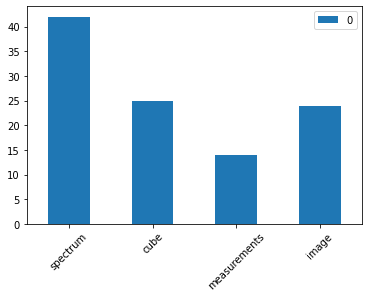

In [4]:
from collections import Counter
dp_types = res['dataproduct_type']
dp_types_counts = Counter(dp_types)
df = pandas.DataFrame.from_dict(dp_types_counts, orient='index')
df.plot(kind='bar', rot=45)

## Exercise: try this out...
<div style="background-color:lightblue; padding: 1em;" title="Try yourself"><b>Cone search: INTERSECTS or CONTAINS ?</b><p>
If you were looking specifically for spectra, whose footprint is a point, you could have used the stricter CONTAINS operator instead, to ensure that only footprints entirely contained in the defined circle are returned.
<p>Just remember, while INTERSECTS is commutative, the order of the CONTAINS operands is important and defined as: <pre>CONTAINS( contained, container )=1</pre>
<p>You might want to repeat the cone search query after changing INTERSECTS with CONTAINS to see the difference. [Answer: images, and measurements derived from those images, no longer show up in the result table given their larger field of view (>2.5')]. </div>

### <a id='point_in_footprint'>3.B Point in footprint</a>

Suppose you are interested in finding extended<sup>(*)</sup> datasets that cover a certain point in the sky (e.g., datasets that could have imaged the progenitor of a supernova).

<small>(*) "Extended" means that their footprint area is > 0.0, excluding from the result set spectra and visibilities whose footprint is a point in the sky.</small>

How to find the datasets that include such point? You can use either the INTERSECTS or the CONTAINS operator, as for a point there is no difference. Here we use CONTAINS.

In [9]:
# Looking for either images or cubes containing the location of SN2016x;

query = """SELECT t_min, abmaglim, dataproduct_type as type, dp_id, obs_release_date
FROM ivoa.ObsCore
WHERE CONTAINS(point('', 193.815, 0.099819), s_region)=1
AND dataproduct_type in ('image', 'cube')
ORDER BY t_min asc"""

# The above query returns all there is, whether observed before or after the SN discovery (which happened on t_min=57408)
# One could imit to only the data taken before the event, by adding the constraint:
# AND t_min < 57408

print(query)
res = tapobs.search(query=query, maxrec=1000)
print("Num matching datasets: %d" % (len(res)))
print(res.to_table())

SELECT t_min, abmaglim, dataproduct_type as type, dp_id, obs_release_date
FROM ivoa.ObsCore
WHERE CONTAINS(point('', 193.815, 0.099819), s_region)=1
AND dataproduct_type in ('image', 'cube')
ORDER BY t_min asc
Num matching datasets: 27
    t_min      abmaglim  type            dp_id              obs_release_date  
      d          mag                                                          
-------------- -------- ----- --------------------------- --------------------
56402.18240388   21.536 image ADP.2017-09-14T08:39:36.119 2017-09-20T20:02:58Z
56402.18240388   21.629 image ADP.2017-09-14T08:39:36.115 2017-09-20T20:02:58Z
56402.18390705   21.374 image ADP.2017-09-14T08:39:36.106 2017-09-20T20:02:58Z
56402.18538167   21.382 image ADP.2017-09-14T08:39:36.144 2017-09-20T20:02:58Z
56402.19168523    21.99 image ADP.2017-09-14T08:39:36.134 2017-09-20T20:02:58Z
56402.20940042   22.588 image ADP.2017-09-14T08:39:36.138 2017-09-20T20:02:58Z
56409.00209078   20.933 image ADP.2017-09-14T08:39:36

### <a id='region_in_footprint'>3.C Region in footprint</a>

If you want to ensure that the matching datasets contain an entire region, you must use the CONTAINS operator. In the first operand you place the entire region you want to have covered, while the second operand is the s_region column. <table><tr><td valign="top">The covered region could be a simple circle, or a more complex shape (e.g. a polygon). Here we show a circle around NGC253:</td><td valign="top"> <img src="./ngc253_circle.png" width="150" height="150"></td></tr></table>

In [10]:
# The provided polygon embraces the (optical) disk of the NGC 253 galaxy:
# see the purple polygon in: https://tinyurl.com/wws5wgd

query = """SELECT t_min, s_fov, dataproduct_type as type, dp_id, obs_release_date
FROM ivoa.ObsCore
WHERE CONTAINS(CIRCLE('', 11.888002, -25.288220, 0.21), s_region)=1
AND dataproduct_type in ('image', 'cube')
ORDER BY t_min asc"""

#CONTAINS(POLYGON('J2000', 11.69167, -25.42802, 11.70837, -25.39377, 11.82948, -25.28317, 11.95405, -25.1965, 12.04864, -25.15928, 12.05789, -25.19052, 11.95461, -25.28743, 11.84107, -25.37337, 11.75762, -25.41363), s_region)=1

# The above query returns all there is, whether observed before or after the SN discovery (which happened on t_min=57408)
# One could imit to only the data taken before the event, by adding the constraint:
# AND t_min < 57408

print(query)
res = tapobs.search(query=query, maxrec=1000)
print("Num matching datasets: %d" % (len(res)))
print(res.to_table())


SELECT t_min, s_fov, dataproduct_type as type, dp_id, obs_release_date
FROM ivoa.ObsCore
WHERE CONTAINS(CIRCLE('', 11.888002, -25.288220, 0.21), s_region)=1
AND dataproduct_type in ('image', 'cube')
ORDER BY t_min asc
Num matching datasets: 7
    t_min          s_fov     ...   obs_release_date  
      d             deg      ...                     
-------------- ------------- ... --------------------
55864.21418374 1.15908954416 ... 2019-04-29T13:08:36Z
55893.13608187 1.45520652527 ... 2015-06-18T11:00:50Z
55897.15708812 1.45500126333 ... 2015-06-18T05:46:38Z
55927.08420409 1.15896704055 ... 2019-04-29T18:06:01Z
 56132.3041874 1.15909942583 ... 2019-05-02T17:40:17Z
56147.27356555 1.15886452083 ... 2019-05-02T17:40:17Z
56180.34451683 1.15887357333 ... 2019-05-02T18:00:17Z


Here above you see the list of datasets large enough to entirely embrace the provided circle. 

### <a id='polygon_search'>3.D Search by polygon</a>
You can search for all datasets intersecting a polygon. This is useful, for example, when looking for optical, infrared, or radio, counterparts of a gravitational wave (GW) event. 
GW spatial probability maps exist, e.g., see: [Ligo Skymap](https://lscsoft.docs.ligo.org/ligo.skymap/). Those maps can be converted into confidence contours at a certain probability level, resulting in counterclockwise polygons that can be used to search for ESO data potentially covering the GW event. 

<table><tr><td>The query example uses a polygon constructed as explained above for the GW170817 event.</td><td><img src="./GW170717_polygon.png" width="100"></td></tr></table>

In [11]:
query = """SELECT t_min, snr, abmaglim, dataproduct_type as type, dp_id
FROM ivoa.ObsCore
WHERE INTERSECTS(s_region, POLYGON('J2000', 196.8311,-23.5212, 196.7432,-23.3586, 196.6553,-23.1962, 196.4795,-23.0339, 196.3916,-22.8719, 196.3037,-22.71, 196.2158,-22.5484, 196.1279,-22.3869, 196.04,-22.2257, 195.9521,-22.0646, 195.8643,-21.9037, 195.7764,-21.7429, 195.7764,-21.5824, 195.6885,-21.422, 195.6006,-21.2618, 195.5127,-21.1018, 195.4248,-20.942, 195.3369,-20.7823, 195.3369,-20.6228, 195.249,-20.4634, 195.1611,-20.3043, 195.1611,-20.1452, 195.0732,-19.9864, 194.9854,-19.8277, 194.8975,-19.6692, 194.8975,-19.5108, 194.8096,-19.3526, 194.7217,-19.1945, 194.6338,-19.0366, 194.6338,-18.8788, 194.5459,-18.7212, 194.458,-18.5637, 194.458,-18.4064, 194.3701,-18.2492, 194.458,-18.0922, 194.458,-17.9353, 194.6338,-18.0137, 194.8096,-18.1707, 194.9854,-18.3278, 195.0732,-18.4851, 195.1611,-18.6425, 195.249,-18.8, 195.3369,-18.9577, 195.4248,-19.1155, 195.5127,-19.2735, 195.6006,-19.4317, 195.6885,-19.59, 195.8643,-19.7484, 195.9521,-19.907, 196.1279,-20.0658, 196.2158,-20.2247, 196.3916,-20.3838, 196.4795,-20.5431, 196.5674,-20.7025, 196.6553,-20.8621, 196.7432,-21.0219, 196.8311,-21.1818, 196.9189,-21.3419, 196.9189,-21.5022, 197.0068,-21.6626, 197.0947,-21.8233, 197.1826,-21.9841, 197.2705,-22.1451, 197.3584,-22.3063, 197.4463,-22.4676, 197.5342,-22.6292, 197.6221,-22.7909, 197.71,-22.9529, 197.7979,-23.115, 197.7979,-23.2773, 197.8857,-23.4399, 197.9736,-23.6026, 198.0615,-23.7655, 198.1494,-23.9287, 198.2373,-24.092, 198.3252,-24.2556, 198.4131,-24.4193, 198.501,-24.5833, 198.501,-24.7475, 198.5889,-24.9119, 198.6768,-25.0765, 198.7646,-25.2414, 198.8525,-25.4064, 198.9404,-25.5717, 199.0283,-25.7373, 199.0283,-25.903, 199.1162,-26.069, 199.1162,-26.2352, 199.2041,-26.4017, 199.2041,-26.5684, 199.2041,-26.7353, 199.2041,-26.9025, 199.1162,-26.9025, 198.9404,-26.7353, 198.7646,-26.5684, 198.5889,-26.4017, 198.501,-26.2352, 198.4131,-26.069, 198.2373,-25.903, 198.1494,-25.7373, 198.0615,-25.5717, 197.9736,-25.4064, 197.8857,-25.2414, 197.7979,-25.0765, 197.71,-24.9119, 197.6221,-24.7475, 197.5342,-24.5833, 197.3584,-24.4193, 197.2705,-24.2556, 197.1826,-24.092, 197.0947,-23.9287, 197.0068,-23.7655, 196.9189,-23.6026))=1
ORDER BY t_min asc"""

print(query)

res = tapobs.search(query=query, maxrec=2000)

print("Num matching datasets: %d" % (len(res)))
print(res.to_table())

SELECT t_min, snr, abmaglim, dataproduct_type as type, dp_id
FROM ivoa.ObsCore
WHERE INTERSECTS(s_region, POLYGON('J2000', 196.8311,-23.5212, 196.7432,-23.3586, 196.6553,-23.1962, 196.4795,-23.0339, 196.3916,-22.8719, 196.3037,-22.71, 196.2158,-22.5484, 196.1279,-22.3869, 196.04,-22.2257, 195.9521,-22.0646, 195.8643,-21.9037, 195.7764,-21.7429, 195.7764,-21.5824, 195.6885,-21.422, 195.6006,-21.2618, 195.5127,-21.1018, 195.4248,-20.942, 195.3369,-20.7823, 195.3369,-20.6228, 195.249,-20.4634, 195.1611,-20.3043, 195.1611,-20.1452, 195.0732,-19.9864, 194.9854,-19.8277, 194.8975,-19.6692, 194.8975,-19.5108, 194.8096,-19.3526, 194.7217,-19.1945, 194.6338,-19.0366, 194.6338,-18.8788, 194.5459,-18.7212, 194.458,-18.5637, 194.458,-18.4064, 194.3701,-18.2492, 194.458,-18.0922, 194.458,-17.9353, 194.6338,-18.0137, 194.8096,-18.1707, 194.9854,-18.3278, 195.0732,-18.4851, 195.1611,-18.6425, 195.249,-18.8, 195.3369,-18.9577, 195.4248,-19.1155, 195.5127,-19.2735, 195.6006,-19.4317, 195.6885,-19.59, 1

---
### <a id='spatial_joins'>4. Spatial joins</a>
Are you interested in finding images in different bands of the same sky region, for photometrical studies?

The following example shows how you can compose a spatial join, so to find:
   * HAWKI images,
   * within 10 degrees from the galactic plane,
   * taken in the J and H filters,
   * where the J and H images overlap,
   * and ensuring that they overlap for at least 80% of the J band image area.

In [12]:
query = """SELECT J.* FROM
      (select * FROM ivoa.Obscore WHERE dataproduct_subtype ='srctbl' 
      AND obs_collection = 'HAWKI' 
      AND gal_lat < 10 AND gal_lat > -10 
      AND em_min < 1.265E-6 AND em_max > 1.265E-6 ) J, 

      (select * FROM ivoa.Obscore WHERE dataproduct_subtype ='srctbl' 
      AND obs_collection = 'HAWKI' 
      AND gal_lat < 10 AND gal_lat > -10 
      AND em_min < 1.66E-6 AND em_max > 1.66E-6 ) H 

WHERE INTERSECTS( J.s_region , H.s_region)=1 and 
ESO_INTERSECTION( J.s_region , H.s_region) > 0.8*AREA( J.s_region )"""

# Let's get a maximum of 20000 images
res = tapobs.search(query=query, maxrec=20000)
print("")
print("Num matching datasets: %d" % (len(res)))
print(res.to_table())


Num matching datasets: 3224
abmaglim access_estsize ... t_xel   target_name   
  mag        kbyte      ...                       
-------- -------------- ... ----- ----------------
  22.076           3456 ...    --            BYF73
  21.984           4752 ...    --            BYF73
  22.059           3625 ...    --            BYF73
   21.96           4852 ...    --            BYF73
  21.999           3156 ...    --            BYF73
  21.904           4262 ...    --            BYF73
  22.046           3398 ...    --            BYF73
   21.95           4518 ...    --            BYF73
  22.133           3795 ...    --            BYF73
  22.051           4968 ...    --            BYF73
     ...            ... ...   ...              ...
  26.322           1512 ...    --            RCW36
  26.481           1056 ...    --            RCW36
  26.531           1085 ...    --            RCW36
  26.586           1062 ...    --            RCW36
  26.272           1520 ...    --            RCW36
  

Notice the J.* in the SELECT part: that is to retrieve just only the information about the J images. You could then repeat the query for the H band. This is useful, for example, to visualise the results in a tool like Aladin, using different colours for the different queries, and hence for the different bands.

Otherwise, you could simply get all of them at once, using SELECT * instead, or using a more selective statement, prepending the column name that you want from the J or H set of results, like in: SELECT J.dp_id, H.dp_id, etc.

---
### <a id='query_by_wavelengths'>5. Query by wavelengths</a>

Please notice that the IVOA ObsCore standard requires the wavelvengths to be stored un meters.

You can always output them in different units rescaling them in the SELECT statement, as in the following query, but you need to use meters when setting a constraint on the em_min and em_max columns. And this even for data which use frequency on the spectral axis (e.g. radio data). That choice makes possible to standardise the query across all observatories. Please remember to use meters.



In [13]:
query="""SELECT obs_collection as collection, dataproduct_type as type, 
dataproduct_subtype as subtype, em_min*1E9 min_wavel_nm, em_max*1E9 max_wavel_nm, em_res_power
FROM ivoa.ObsCore
WHERE target_name = 'a370'
and em_res_power < 3000"""

res = tapobs.search(query=query, maxrec=3)
print(res.to_table())


collection     type     subtype     min_wavel_nm    max_wavel_nm em_res_power
---------- ------------ -------- ------------------ ------------ ------------
092.A-0472        image          1981.9999999999998       2307.0          6.0
     HAWKI measurements   srctbl             1181.0       1335.0          8.0
     HAWKI        image pawprint             1181.0       1335.0          8.0


---
### <a id='obscore_columns'>6. Units of the ivoa.ObsCore columns</a>

The ivoa.ObsCore table contains many various scientifically intersting parameters describing the reduced data, from signal-to-noise ratio of the processed spectra, to the limiting magnitude for images and cubes, to the spectral resolution, the min/max wavelengths (for most data types), the (linear) spatial field of view, etc.

Query constraints can be build on any of those parameters, using the corresponding column names; the values in the constraints must use the correct units.

The following query can be used to find out the columns of the ObsCore table, along with their units, UCDs, descriptions, etc.

In [14]:
query="""SELECT column_name, unit, ucd -- and others like description, etc.
from TAP_SCHEMA.Columns
where table_name='ivoa.ObsCore'"""

res = tapobs.search(query=query)
print("{:20s} \t {}\t{}".format('column_name', 'unit', 'UCD'))
print("{:20s} \t {}\t{}".format('--------------------','------','---------------------------'))
for row in res:
    print("{:20s} \t {}\t{}".format(row['column_name'].decode(), row['unit'].decode(), row['ucd'].decode()))

column_name          	 unit	UCD
-------------------- 	 ------	---------------------------
abmaglim             	 mag	phot.mag;stat.max
access_estsize       	 kbyte	phys.size;meta.file
access_format        	 	meta.code.mime
access_url           	 	meta.ref.url
bib_reference        	 	meta.bib.bibcode
calib_level          	 	meta.code;obs.calib
dataproduct_subtype  	 	meta.code.class
dataproduct_type     	 	meta.code.class
dp_id                	 	meta.id
em_max               	 m	em.wl;stat.max
em_min               	 m	em.wl;stat.min
em_res_power         	 	spect.resolution
em_xel               	 	meta.number
facility_name        	 	meta.id;instr.tel
filter               	 	meta.id;instr.filter
gal_lat              	 deg	pos.galactic.latitude
gal_lon              	 deg	pos.galactic.longitude
instrument_name      	 	meta.id;instr
multi_ob             	 	meta.code.multip;obs
n_obs                	 	meta.number;obs
o_calib_status       	 	meta.code.qual
o_ucd                	 	meta.ucd
obs_c